## Setting up environment

In [2]:
pip install pandas numpy streamlit gensim scikit-learn


## Load and Explore the Dataset

In [3]:
import pandas as pd

# Define the dataset URL
url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/sample-data.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows to understand the structure
df.head()


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [16]:
# Get dataset info
df.info()

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Check for duplicate rows based on 'id' and 'description' only
duplicate_count = df.duplicated(subset=["id", "description"]).sum()
print("\nDuplicate rows:", duplicate_count)

# Ensure all descriptions are strings before checking length
df["description"] = df["description"].astype(str)

# Check description length distribution
df["desc_length"] = df["description"].apply(len)
print("\nDescription Length Statistics:\n", df["desc_length"].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              500 non-null    int64 
 1   description     500 non-null    object
 2   tokenized_desc  500 non-null    object
 3   vector          500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB

Missing Values:
 id                0
description       0
tokenized_desc    0
vector            0
dtype: int64

Duplicate rows: 0

Description Length Statistics:
 count     500.000000
mean     1016.356000
std       414.537361
min       309.000000
25%       710.750000
50%       939.500000
75%      1271.500000
max      3415.000000
Name: desc_length, dtype: float64


## Preprocess Data

In [19]:
import re

# Function to clean HTML tags and strip extra spaces
def clean_html(text):
    text = text.strip()  # Remove leading/trailing spaces
    return re.sub(r'<[^>]*>', '', text)

# Apply the cleaning function to the description column
df["description"] = df["description"].astype(str).apply(clean_html)



In [21]:
# Extract product names (before the first '-')
df["product_name"] = df["description"].apply(lambda x: x.split(" - ")[0])


In [23]:
from gensim.parsing.preprocessing import remove_stopwords


In [25]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

# Tokenize and remove stopwords
df["tokenized_desc"] = df["description"].apply(lambda x: simple_preprocess(remove_stopwords(str(x))))

# Show tokenized descriptions
df.head()


,id,description,tokenized_desc,vector,desc_length,product_name
0,1,Active classic boxers - There's a reason why o...,"[active, classic, boxers, there, reason, boxer...","[-0.31052437, 0.72945154, -0.004279416, 0.2273...",917,Active classic boxers
1,2,Active sport boxer briefs - Skinning up Glory ...,"[active, sport, boxer, briefs, skinning, glory...","[-0.30757818, 0.664468, 0.022860603, 0.1919254...",955,Active sport boxer briefs
2,3,Active sport briefs - These superbreathable no...,"[active, sport, briefs, these, superbreathable...","[-0.31454727, 0.6867121, 0.027406529, 0.169458...",856,Active sport briefs
3,4,"Alpine guide pants - Skin in, climb ice, switc...","[alpine, guide, pants, skin, in, climb, ice, s...","[-0.3598595, 0.5544191, 0.089493334, -0.032980...",1246,Alpine guide pants
4,5,"Alpine wind jkt - On high ridges, steep ice an...","[alpine, wind, jkt, on, high, ridges, steep, i...","[-0.28834426, 0.5535524, 0.04960581, -0.014366...",1777,Alpine wind jkt


## Train Word2Vec Model

In [26]:
from gensim.models import Word2Vec

# Train a Word2Vec model using the tokenized product descriptions
model = Word2Vec(sentences=df["tokenized_desc"], vector_size=100, window=5, min_count=1, workers=4)

# Save the trained model
model.save("word2vec_model.model")

# Confirm the file is saved
import os
print("Model saved:", os.path.exists("word2vec_model.model"))


Model saved: True


In [27]:
# Load the trained model
model = Word2Vec.load("word2vec_model.model")

# Check the most similar words to a common product-related word
print(model.wv.most_similar("jacket", topn=5))  # Replace "jacket" with a relevant word from your dataset


[('high', 0.9995107054710388), ('reinforced', 0.9994060397148132), ('quickly', 0.9991930723190308), ('vest', 0.9991602301597595), ('new', 0.9991601705551147)]


## Generate Product Embeddings

In [28]:
import numpy as np

# Function to convert text into a vector by averaging word embeddings
def get_vector(text):
    vectors = [model.wv[word] for word in text if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)  # 100 is the vector_size

# Apply function to generate product vectors
df["vector"] = df["tokenized_desc"].apply(get_vector)

# Check a sample product embedding
print("Product ID:", df["id"].iloc[0])
print("Vector representation:\n", df["vector"].iloc[0])

# Check the shape of the matrix
vectors = np.vstack(df["vector"].values)
print("Vector matrix shape:", vectors.shape)


Product ID: 1
Vector representation:
 [-0.15752764  0.37229562  0.19448332 -0.07842173  0.25029513 -0.61681926
  0.3348309   1.0194579  -0.37136522 -0.31108612 -0.18630265 -0.6728514
 -0.05841605  0.18401515  0.03993623 -0.3935657   0.27834922 -0.3194492
 -0.07874002 -1.0805597   0.08898086 -0.05682158  0.49397376 -0.09646183
 -0.20134601  0.08627719 -0.27515876 -0.09261081 -0.46790883 -0.04814124
  0.5752899  -0.01604998  0.09479025 -0.40389463 -0.23406161  0.48535094
  0.12389891 -0.43363214 -0.27073768 -0.6874483   0.22697231 -0.47072482
 -0.331814    0.2253615   0.35921428 -0.16734445 -0.25986078 -0.28482482
  0.18887492  0.07971667  0.13810699 -0.51845    -0.23594539  0.1036773
 -0.47327265  0.113109    0.20286337 -0.20014329 -0.44031778  0.05980067
  0.1910955  -0.14379135  0.04010103 -0.18226707 -0.6831017   0.5015362
  0.28629574  0.43577212 -0.74137306  0.56444967 -0.25612345  0.2988825
  0.48915616 -0.00186629  0.28368574  0.20532311 -0.05865788  0.19932012
 -0.41365913  0.13

In [11]:
# Check the most similar words to a given word (if applicable)
model.wv.most_similar("laptop", topn=5)  # Replace "laptop" with a word from your dataset


[('steel', 0.9971753358840942),
 ('repair', 0.9968888759613037),
 ('gear', 0.9968738555908203),
 ('low', 0.9966602921485901),
 ('alpine', 0.996509313583374)]

Visualize Word Embeddings using PCA

In [32]:
!pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------------------------------------ --- 7.3/8.0 MB 37.8 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 19.9 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------------------------------- - 2.1/2.2 MB 39.0 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 8.2 MB/s eta 0:00:00


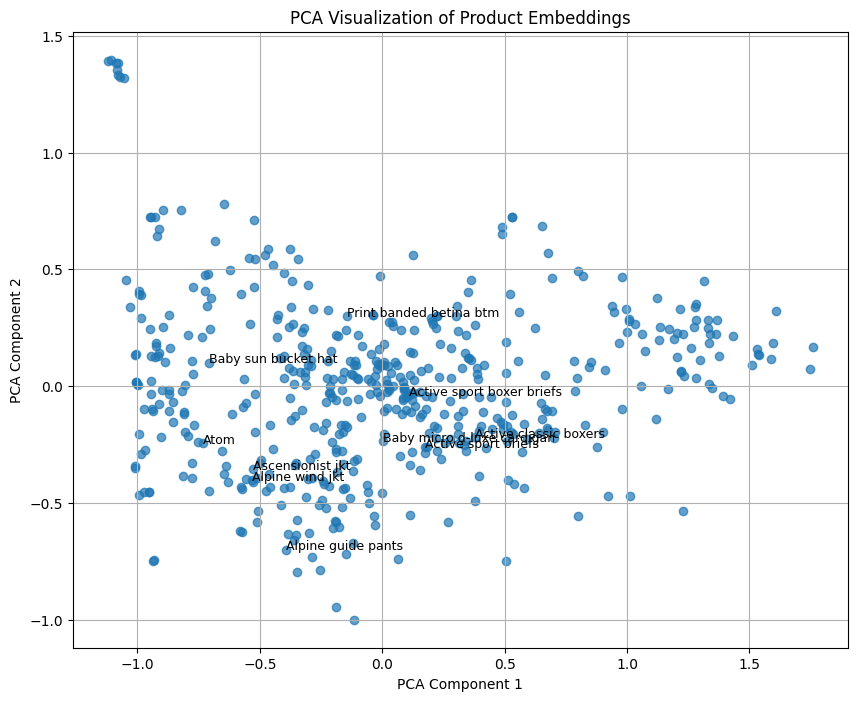

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# Extract categories from the product names (first word)
df["category"] = df["product_name"].apply(lambda x: x.split()[0] if isinstance(x, str) else "Other")

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)  # 'vectors' contains the 100D product vectors

# Assign colors based on unique categories
unique_categories = df["category"].unique()
category_colors = {category: color for category, color in zip(unique_categories, sns.color_palette("hsv", len(unique_categories)))}

# Create a scatter plot
plt.figure(figsize=(12, 8))

# Plot each product with its corresponding category color
for category in unique_categories:
    indices = df[df["category"] == category].index
    plt.scatter(reduced_vectors[indices, 0], reduced_vectors[indices, 1], 
                label=category, alpha=0.7, c=[category_colors[category]])

# Annotate some points with product names
for i in range(15):  # Annotate only the first 15 products for readability
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], df["product_name"].iloc[i], fontsize=10, color='black')

# Improve visualization aesthetics
plt.title("PCA Visualization of Product Embeddings (Colored by Category)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# Show the plot
plt.show()


## Compute Cosine Similarity

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Convert product vectors into a NumPy array
vectors_array = np.vstack(df["vector"].values)  # Stack all vectors into a matrix

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(vectors_array)

# Display the shape of the similarity matrix
print("Similarity matrix shape:", similarity_matrix.shape)

# Show a sample of the similarity matrix
pd.DataFrame(similarity_matrix).iloc[:5, :5]  # Display first 5 rows & 5 columns


Similarity matrix shape: (500, 500)


,0,1,2,3,4
0,1.000000,0.998172,0.997479,0.961955,0.963079
1,0.998172,1.000000,0.999711,0.973540,0.972289
2,0.997479,0.999711,1.000000,0.977734,0.976943
3,0.961955,0.973540,0.977734,1.000000,0.997973
4,0.963079,0.972289,0.976943,0.997973,1.000000


### Build the Recommendation Function

In [41]:
print(df.columns)  # This will list all column names


Index(['id', 'description'], dtype='object')


In [42]:
import numpy as np
import pandas as pd

def recommend_products(product_id, num_recommendations=5):
    """
    Given a product ID, return the top N most similar products based on cosine similarity.
    """
    try:
        # ✅ Find the index of the selected product
        product_index = df[df["id"] == product_id].index[0]

        # ✅ Get similarity scores for the selected product
        similarity_scores = similarity_matrix[product_index]

        # ✅ Get indices of the top N similar products (excluding itself)
        similar_indices = np.argsort(similarity_scores)[-num_recommendations-1:-1][::-1]

        # ✅ Retrieve recommended product details (Only using 'id' and 'description')
        recommendations = df.iloc[similar_indices][["id", "description"]]

        # ✅ Shorten descriptions for better readability
        recommendations["short_description"] = recommendations["description"].apply(lambda x: x[:200] + "..." if len(x) > 200 else x)

        # ✅ Display formatted recommendations
        print(f"\n🔹 **Recommendations for Product ID: {product_id}** 🔹\n")
        for idx, row in recommendations.iterrows():
            print(f"🆔 **ID**: {row['id']}")
            print(f"📖 **Description**: {row['short_description']}\n")

        return recommendations[["id", "short_description"]]

    except IndexError:
        print(f"❌ Error: Product ID {product_id} not found in dataset.")
        return pd.DataFrame()  # Return empty dataframe if product ID is invalid

# ✅ Test the function with a sample product ID
sample_product_id = df["id"].iloc[0]  # Selecting the first product
recommendations = recommend_products(sample_product_id)



🔹 **Recommendations for Product ID: 1** 🔹

🆔 **ID**: 61
📖 **Description**: Cap 3 bottoms - Like birds and clouds, kids stay on the move. Their abandon doesn't need purpose, just a little warmth when the sun sets or a quick dry when the water sprays. Worn alone or under layer...

🆔 **ID**: 234
📖 **Description**: Vitaliti dress - The ocean has had its way with you. Your salted, sun-scorched body begs for mercy. Let this soft, slip-on dress comfort you. Sturdy, wrinkle-resistant Vitaliti fabric blends 61% organ...

🆔 **ID**: 171
📖 **Description**: Cap 1 bottoms - Made from our lightest-weight Capilene baselayer fabric, these soothing bottoms are soft and silky next to the skin. They wick perspiration, dry quickly, and breathe. A perfect layer u...

🆔 **ID**: 264
📖 **Description**: R1 p/o - Here's to trails that circle the globe and to never-ending hand cracks. And here's to staying mobile, comfortable and warm with the R1 Pullover's high/low grid polyester that stretches, breat...

🆔 **I